# OmniFold with ALEPH Open Data

### Imports

In [1]:
import os

import energyflow as ef
import energyflow.archs
import matplotlib.pyplot as plt
import numpy as np
import uproot

import omnifold
import modplot
import ibu

Using TensorFlow backend.


### Plot Style

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

## Loading the Data

In [3]:
aleph_path = '/callisto/ALEPH'

# load data, currently just get thrust values
thrust_arrs = []
years = ['1992', '1993', '1994', '1995']
#years = ['1994']
for year in years:
    data_file = uproot.open(os.path.join(aleph_path, 'LEP1Data{}_recons_aftercut-MERGED.root'.format(year)))
    passesLEP1TwoPC = data_file['t']['passesLEP1TwoPC'].array()
    ISR = data_file['t']['passesISR'].array()
    WW = data_file['t']['passesWW'].array()
    All = data_file['t']['passesAll'].array()
    ## ANTHONY U ARE HERE AND JUST UPDATED THE MASK TO INCLUDE WW AND ISR CUTS
    event_mask = All
    thrust_arrs.append(data_file['t']['Thrust'].array()[event_mask])

# dictionary to hold observable values
nature = {'data_thrusts': np.concatenate(thrust_arrs)}

In [4]:
aleph_path = '/callisto/ALEPH'

# load mc, currently just get thrust values
mc_file = uproot.open(os.path.join(aleph_path, 'alephMCRecoAfterCutPaths_1994.root'))
passesLEP1TwoPC = mc_file['t']['passesLEP1TwoPC'].array()
ISR = mc_file['t']['passesISR'].array()
WW = mc_file['t']['passesWW'].array()
All = mc_file['t']['passesAll'].array()
#event_mask = passesLEP1TwoPC * ISR * WW
# Anthony YOU ARE HERE and trying to retrace which mask you need to use,
# which thrust you need to use, and what the corrections applied are
event_mask = All
synthetic = {'gen_thrusts': mc_file['tgen']['Thrust'].array()[event_mask], # removed 1 - before all three
             'genBefore_thrusts': mc_file['tgenBefore']['Thrust'].array(),
             'sim_thrusts': mc_file['t']['Thrust'].array()[event_mask]}

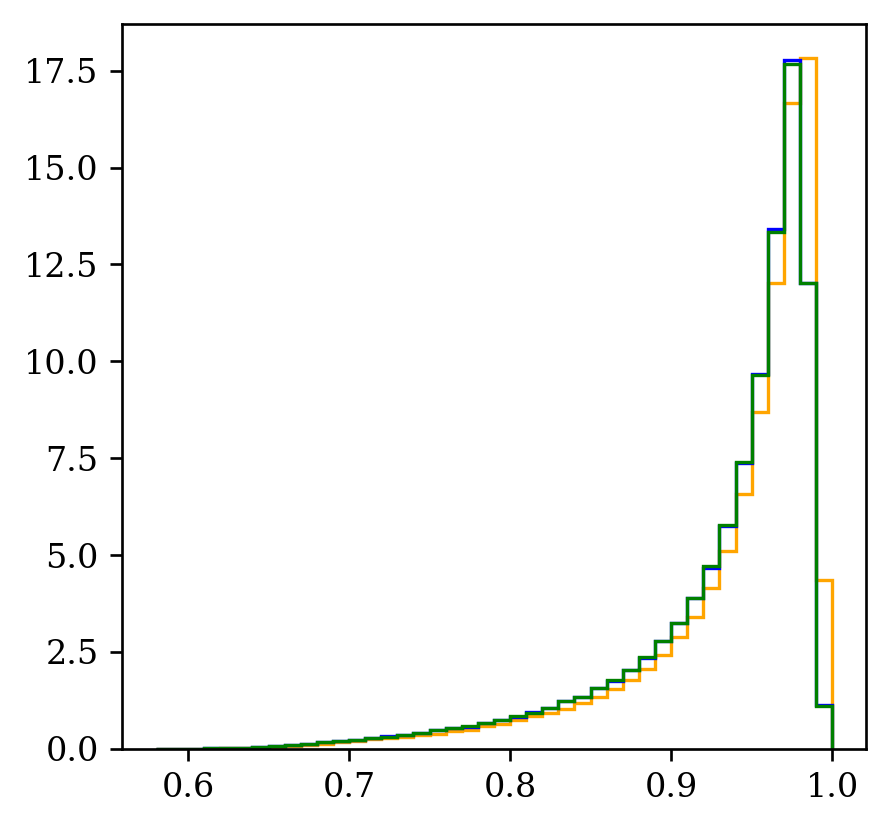

In [5]:
# compute the distributions to determine the bin-by-bin corrections
bins = np.linspace(0, 0.5, 51)

# ANTHONY TEST
# binsTEST = np.linspace(0,0.42,43)
binsTEST = np.linspace(0.58, 1.0, 43)

density = True

#plt.hist(nature['data_thrusts'], bins=bins, histtype='step', color='black', density=density)
simhist = plt.hist(synthetic['sim_thrusts'], bins=binsTEST, histtype='step', color='orange', density=density)[0]
genhist = plt.hist(synthetic['gen_thrusts'], bins=binsTEST, histtype='step', color='blue', density=density)[0]
genbhist = plt.hist(synthetic['genBefore_thrusts'], bins=binsTEST, histtype='step', color='green', density=density)[0]

#plt.yscale('log')

plt.show()

## Specifying the Unfolding Problem

In [6]:
# how many iterations of the unfolding process
itnum = 3

In [7]:
# the observables to use for multifold (a single one just indicates unifold)
obs_multifold = ['Thrust']

In [8]:
# a dictionary to hold information about the observables
obs = {}

In [9]:
# the thrust and histogram style information
obs.setdefault('Thrust', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_thrusts'],
    'nbins_det': 42, 'nbins_mc': 42, # 'nbins_det': 50, 'nbins_mc': 50,
    'yscale': 'log',
    'xlim': (0.58, 1.0), 'ylim': (10**-4.5, 20), 'ylim_ratio': (0.7, 1.3),
    'ytick_ratio_step': 0.15,
    'xlabel': r'Thrust $\tau$', 'symbol': r'$\tau$',
    'ylabel': r'Normalized Cross Section', 'ylabel_ratio': 'Ratio to\nALEPH',
    'stamp_xy': (0.5, 0.9),
    'legend_loc': 'lower left', 'legend_ncol': 1
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': r'\textsc{Pythia} 6 Generation'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': 'ALEPH Measurement'}
ibu_style0 = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
ibu_style1 = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'black', 'zorder': 1}
ibu_style2 = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'purple', 'zorder': 1}
ibu_style3 = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'red', 'zorder': 1}
ibu_style4 = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'blue', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

In [10]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['dataobs'] = ob['func'](nature, 'data')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                         ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

Done with Thrust


## OmniFold

In [11]:
model_layer_sizes = [10, 10]
# model_layer_sizes = [100, 100, 100] # use this for the full network size

# set up the array of data/simulation detector-level observables
ob0 = obs_multifold[0]
X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'])) for obkey in obs_multifold]).T
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs[ob0]['dataobs'])), 
                                                np.zeros(len(obs[ob0]['simobs'])))))

# set up the array of generation particle-level observables
X_gen = np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen = ef.utils.to_categorical(np.concatenate((np.ones(len(obs[ob0]['genobs'])), 
                                                np.zeros(len(obs[ob0]['genobs'])))))

# standardize the inputs
X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)

# Specify the training parameters
# model parameters for the Step 1 network
det_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes,
            'patience': 10, 'filepath': 'Step1_{}', 'save_weights_only': False, 
            'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# model parameters for the Step 2 network
mc_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes, 
           'patience': 10, 'filepath': 'Step2_{}', 'save_weights_only': False, 
           'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# general training parameters
#fitargs = {'batch_size': 500, 'epochs': 2, 'verbose': 1}
fitargs = {'batch_size': 500, 'epochs': 10, 'verbose': 1} # use this for a full training

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [12]:
# only run this if you want to re-train the OF model. Otherwise will used the saved version
if False:

    # apply the OmniFold procedure to get weights for the generation
    multifold_ws = omnifold.omnifold(X_gen, Y_gen, X_det, Y_det, wdata, winit,
                                    (ef.archs.DNN, det_args), (ef.archs.DNN, mc_args),
                                fitargs, val=0.2, it=itnum, trw_ind=-2, weights_filename='ThrustTest2')

## Plot Unfolding Results

In [13]:
with open('HEPData-ins636645-v1-Table_54.csv', 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


In [14]:
multifold_ws = np.load('ThrustTest.npy')

[0.81946147 0.93024259 0.93024259 0.99277023 0.98661007 0.95900709
 0.9920284  0.99294745 1.01082625 0.99009691 1.00978779 1.00966851
 1.00650388 1.00564515 1.01185689 1.0238318  1.03451068 1.04435269
 1.05302105 1.07932633 1.05803029 1.07975679 1.1019594  1.09907728
 1.11211239 1.12861591 1.14600958 1.15025395 1.18784237 1.18639379
 1.20215447 1.20659524 1.22108181 1.24099706 1.24920238 1.25554617
 1.25401389 1.25330861 1.24709828 1.23994608 1.24663146 1.22269974]


<module 'matplotlib.pyplot' from '/home/pkomiske/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

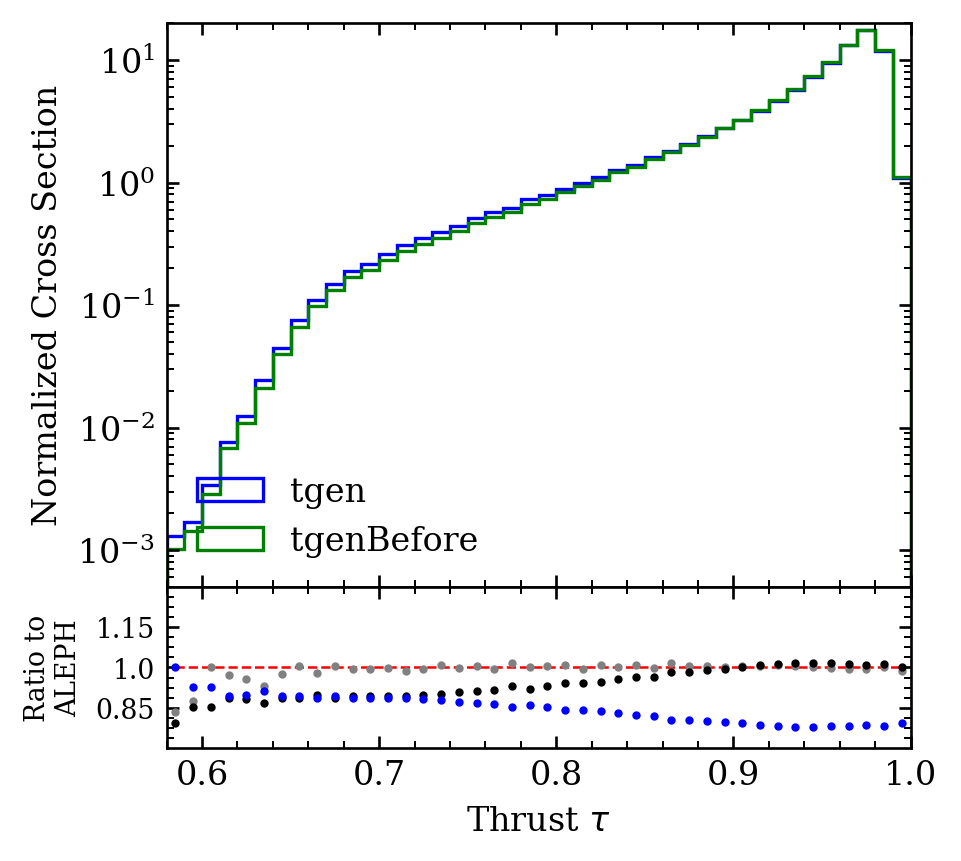

In [15]:
#fig, (ax1, ax2) = plt.subplots(nrows=2)

fig, [ax0, ax1] = modplot.axes(**ob)

# Proper cuts applied 
ISR = mc_file['t']['passesISR'].array()
WW = mc_file['t']['passesWW'].array()
All = mc_file['t']['passesAll'].array()
event_mask = passesLEP1TwoPC * ISR * WW

tgen = mc_file['tgen']['Thrust'].array()
tgenBefore = mc_file['tgenBefore']['Thrust'].array()


tgenHist, tgenbins, tgenpatches = ax0.hist(tgen, bins=binsTEST, histtype='step', color='blue', density=True, label='tgen')
tgenBeforeHist, tgenBeforebins, tgenBeforepatches = ax0.hist(tgenBefore, bins=binsTEST, histtype='step', color='green', density=True, label='tgenBefore')
ax0.set_yscale('log')
ax0.set_ylim(0.5*10**-3, 20)
#ax1.legend()

#ax1.yscale('log')

#ax2.bar(tgenbins[:-1],     # this is what makes it comparable
 #       tgenBeforeHist / (tgenHist + 10**-50), # maybe check for div-by-zero!
  #      alpha=0.4)

#ax1.set_ylabel('Data')
#ax2.set_ylabel('Ratio (a/b)')

corrs1 = genbhist/(genhist + 10**-50)
corrs2 = tgenBeforeHist/(tgenHist + 10**-50)

# removed 0 (underflow) bin from the correction below
corrTestT = [1,0.9285714,0.9285714,0.8939394,0.8971962,0.9121951,0.8943299,0.8938462,0.884575,0.8953488,0.8851064,0.8851675, 0.8867925, 0.8872348,0.8840485, 0.8779925, 0.8726858, 0.8678712, 0.8636898, 0.8513274, 0.8612982, 0.8511291, 0.8410661, 0.8423542, 0.8365706, 0.8293999, 0.8220196, 0.8202455, 0.8049728, 0.8055472, 0.7993565, 0.7976353, 0.7920892, 0.784632, 0.7816142,0.7793024, 0.7798591, 0.7801157, 0.7823851, 0.7850208, 0.7825564, 0.7914762]
corrTest1MT = list(reversed(corrTestT))

ratioBins = (tgenbins[1:] + tgenbins[:-1])/2

ax1.plot([np.min(ratioBins), np.max(ratioBins)], [1, 1], '--', color='red', lw=0.75)
ax1.errorbar(ratioBins, corrs1, color='gray', **modplot.style('errorbar'), label='With Mask') # with mask
ax1.errorbar(ratioBins, corrs2, color='black', **modplot.style('errorbar'), label='Without Mask') # without mask
ax1.errorbar(ratioBins, corrTestT, color='blue', **modplot.style('errorbar'), label='Hard Coded') # hard coded in

# legend style and ordering
loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
order = [0,1]
modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

x = corrs2 + 0.15
y = np.array(corrTestT) + 0.15
print(x/y)

plt


[3.31769786e-03 3.82855168e-03 4.34392931e-03 9.91230848e-03
 1.38169610e-02 2.51318767e-02 4.55823655e-02 7.15685194e-02
 1.05150662e-01 1.34278247e-01 1.67386527e-01 1.87362279e-01
 2.22572575e-01 2.61559502e-01 2.98203817e-01 3.38737489e-01
 3.94200580e-01 4.60256983e-01 5.14348198e-01 5.50502824e-01
 6.39107853e-01 6.93119816e-01 7.75608311e-01 8.92130431e-01
 9.98340030e-01 1.18515249e+00 1.29495617e+00 1.51990396e+00
 1.70128915e+00 1.97383533e+00 2.29047783e+00 2.72042362e+00
 3.21083373e+00 3.88623443e+00 4.70142669e+00 5.79420649e+00
 7.44978180e+00 9.82769072e+00 1.37626261e+01 1.80104054e+01
 1.17955442e+01 1.06484356e+00]
[0.83410782 0.87581321 1.00092938 0.97149028 0.95624504 0.9326842
 0.97414866 1.00608881 0.9786789  1.00456346 0.99588438 0.99370945
 0.9975735  0.98685075 0.99517067 1.00878552 0.99764018 1.00486661
 0.99611722 1.01835252 1.00052093 1.00513262 1.01090874 0.99299128
 1.0090461  0.999918   1.01105126 0.9995662  1.01604383 1.00569668
 1.00581246 1.00234905 1

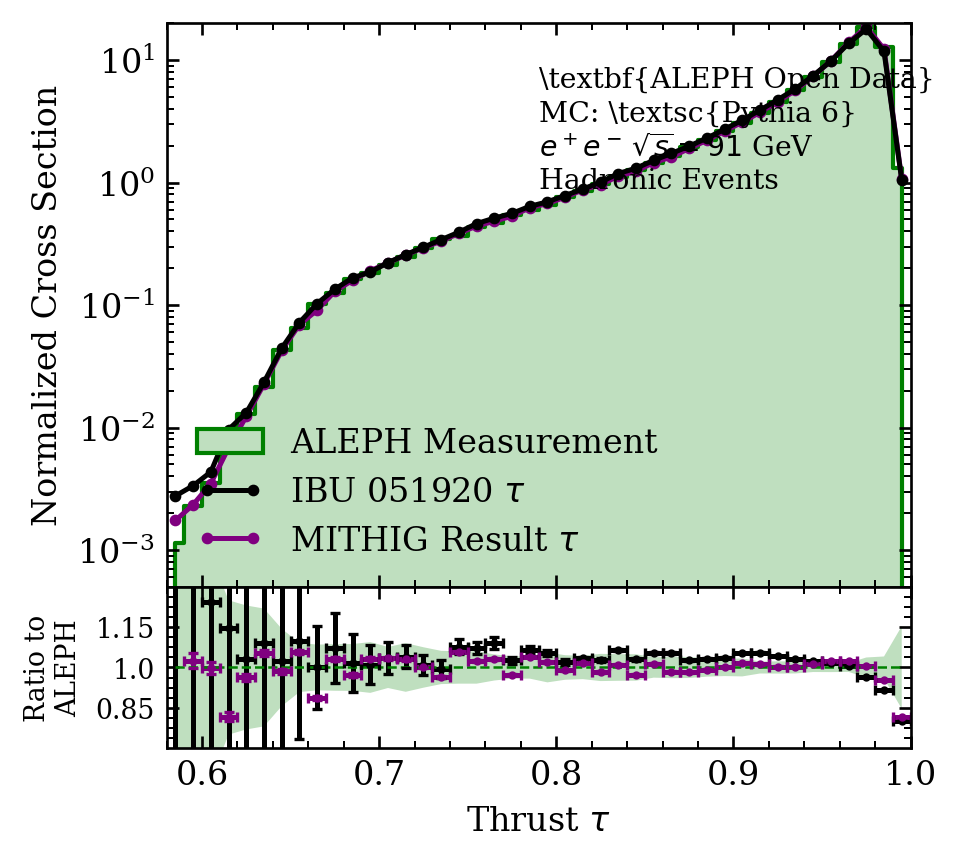

In [19]:
for i,(obkey,ob) in enumerate(obs.items()):

    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    #if ob.get('yscale') is not None:
     #   ax0.set_yscale(ob['yscale'])

        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    #ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='ALEPH Open Data', **hist_style)

    # plot the "sim" histogram of the observable
    #ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='ALEPH Open Simulation', **hist_style)

    # plot the "gen" histogram of the observable
    #ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    #ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)
    aleph_midbins = hepdata[::-1,0] # EDIT HERE
    aleph_thrust = hepdata[::-1,3]
    aleph_errs = np.linalg.norm(hepdata[::-1,[-1,-3,-5]], axis=1)
    ax0.fill_between(aleph_midbins, aleph_thrust, **truth_style)
    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    #of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=multifold_ws[2*itnum], 
     #                                              bins=ob['bins_mc'], density=True)[:2]
    #of_histgen *= corrs
    #ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label=r'UniFold $1-\tau$')

    ### ANTHONY edits here 
    
    # plot the IBU distribution before and after correction
    ibu_hist = ob['ibu_phis'][itnum]
    ibu_hist_corr1 = ob['ibu_phis'][itnum]*corrs1
    print(ob['ibu_phis'][itnum])
    print(corrs1)
    ibu_hist_corr2 = ob['ibu_phis'][itnum]*corrs2
    ibu_hist_corrTest = ob['ibu_phis'][itnum]*corrTestT
    
    scaleRatio = 1.0/((ob['midbins_mc'][1] - ob['midbins_mc'][0])*np.sum(ibu_hist_corrTest))
    ibu_hist_corrTest *= scaleRatio
    
    mithigResult = np.array([1.069774,12.2987, 18.6592, 13.9147, 9.84372, 7.3845, 5.66399, 4.56175, 3.74498, 3.10906, 2.63452, 2.21059, 1.89997, 1.61367, 1.45827, 1.23605, 1.12457, 0.964038, 0.871965, 0.759606, 0.674833, 0.623541, 0.531461, 0.484212, 0.441152, 0.386028, 0.331683, 0.294767, 0.255663, 0.221432, 0.190178, 0.159378, 0.129585, 0.0910061, 0.0693034, 0.0426711, 0.0226695, 0.012361, 0.00684788, 0.00349327, 0.00234669, 0.00174467, 0.000475811])
    mithigResult = np.array(list(reversed(mithigResult)))
    mithigResult_errors = np.array([0.004428908, 0.0233364, 0.0275857, 0.0206703, 0.0160856, 0.0131812, 0.0110725, 0.00964027, 0.00849579, 0.00757102, 0.00690456, 0.00612002, 0.00560385, 0.00505261, 0.00479964, 0.00432782, 0.00416696, 0.0037444, 0.00362121, 0.00329415, 0.00314808, 0.00299579, 0.00273737, 0.00262936, 0.00255939, 0.00235433, 0.00217079, 0.00207108, 0.00195026, 0.00182395, 0.00175487, 0.00160134, 0.00146113, 0.00125216, 0.00120719, 0.000954147, 0.00076159, 0.000561817, 0.000470602, 0.000357146, 0.000446264, 0.000433266, 0.000237906])
    print(len(mithigResult))
    print(len(ob['midbins_mc']))
    ax0.plot(ob['midbins_mc'], mithigResult[1:], **ibu_style2, label='MITHIG Result ' + ob['symbol'])

    #ax0.plot(ob['midbins_mc'], ibu_hist, **ibu_style0, label='IBU' + ob['symbol'])
    ax0.plot(ob['midbins_mc'], ibu_hist_corr1, **ibu_style1, label='IBU 051920 ' + ob['symbol'])
    #ax0.plot(ob['midbins_mc'], ibu_hist_corr2, **ibu_style2, label='Corrected Unmasked IBU ' + ob['symbol'])
    #ax0.plot(ob['midbins_mc'], ibu_hist_corrTest, **ibu_style3, label='IBU ' + ob['symbol'])
    
    ax0.set_yscale('log')
    ax0.set_ylim(0.5*10**-3, 20)

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    aleph_thrust_test = np.array(list(reversed(aleph_thrust)))
    
    ibu_ratio = ibu_hist[:len(hepdata)]/(aleph_thrust_test + 10**-50)
    ibu_ratio_hist_corr1 = ibu_hist_corr1[:len(hepdata)]/(aleph_thrust_test + 10**-50)
    #ibu_ratio_hist_corr2 = ibu_hist_corr2[:len(hepdata)]/(aleph_thrust_test + 10**-50)
    #ibu_ratio_hist_corrTest = ibu_hist_corrTest[:len(hepdata)]/(aleph_thrust_test + 10**-50)
    

    mithigResult_ratio = mithigResult[1:]/(aleph_thrust_test + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '--', color='green', lw=0.75)
    
    # ratio uncertainties
    aleph_unc_ratio = aleph_errs/(aleph_thrust + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc'][:len(hepdata)]/(aleph_thrust + 10**-50)
    
    aleph_unc_ratio_test = np.array(list(reversed(aleph_unc_ratio)))
    ibu_unc_ratio_corrected1 = list(reversed(ob['ibu_phi_unc'][:len(hepdata)]))/(aleph_thrust_test + 10**-50)*corrs1
    ibu_unc_ratio_corrected2 = list(reversed(ob['ibu_phi_unc'][:len(hepdata)]))/(aleph_thrust_test + 10**-50)*corrs2 
    
    
    aleph_midbins_TEST = np.array(list(reversed(aleph_midbins)))
    ax1.fill_between(aleph_midbins_TEST, 1 - aleph_unc_ratio_test, 1 + aleph_unc_ratio_test, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(aleph_midbins_TEST, ibu_ratio_hist_corr1, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio_corrected1, 
                                              color=ibu_style1['color'], **modplot.style('errorbar'))
    ax1.errorbar(aleph_midbins_TEST, mithigResult_ratio, xerr=ob['binwidth_mc']/2, yerr=mithigResult_errors[1:], 
                                              color=ibu_style2['color'], **modplot.style('errorbar'))
    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [2,1,0]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'\textbf{ALEPH Open Data}',
                  line_1=r'MC: \textsc{Pythia 6}',
                  line_2=r'$e^+e^-\,\sqrt{s}=91$ GeV',
                  line_3='Hadronic Events')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('IBU_Crosscheck_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()

[1.58615539 1.42886199 1.24466946 1.4062325  1.06887795 1.033993
 1.04061064 1.03897192 1.13078941 1.04094626 1.04592621 0.97899687
 1.0027119  1.00961106 1.0067738  1.03024114 1.01876117 1.04838439
 1.05811318 1.05483928 1.02549917 1.03236998 1.03220514 1.01595562
 1.04494959 1.05378528 1.05923471 1.04181299 1.07121303 1.04479525
 1.04216121 1.03503259 1.03823177 1.04292421 1.03839107 1.02889048
 1.01038172 0.99620392 0.98411233 0.95969744 0.95897859 0.98230039]


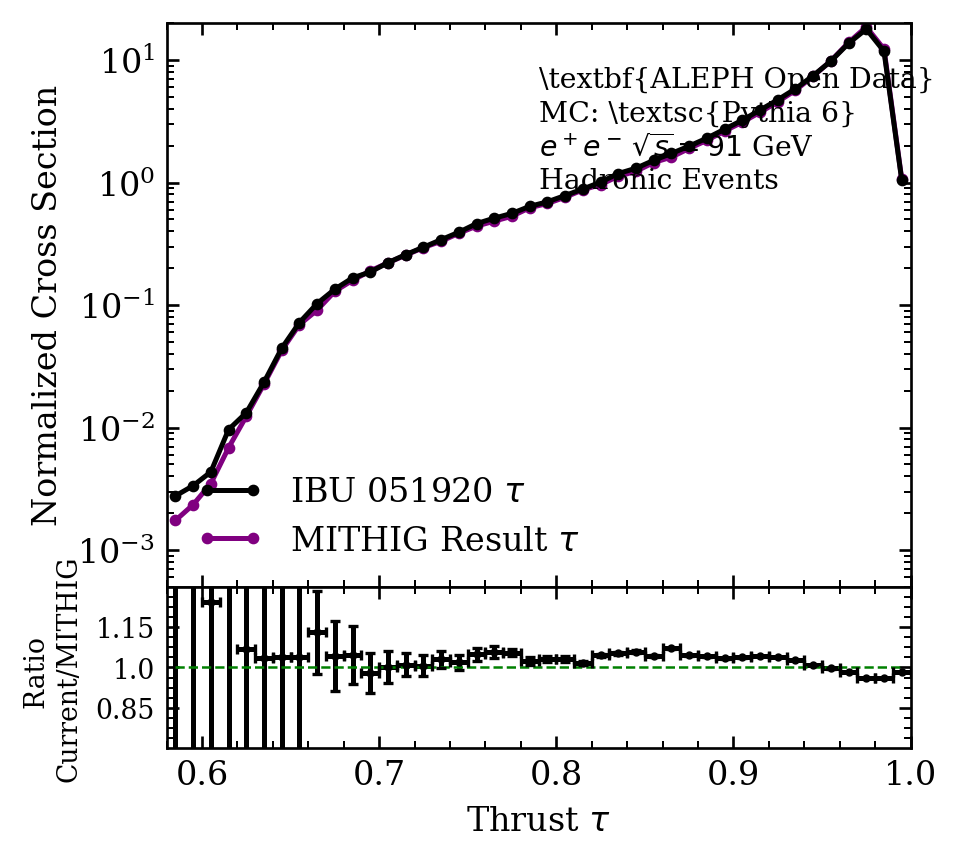

In [17]:
# Get various ratios

# ratio of current ibu to mithig result
ibu_To_MITHIG_ratio = ibu_ratio_hist_corr1 / mithigResult_ratio
print(ibu_To_MITHIG_ratio)

# get the styled axes on which to plot
fig, [ax0,ax1] = modplot.axes(**ob)
ax0.set_yscale('log')
ax0.set_ylim(0.5*10**-3, 20)
    
ax0.plot(ob['midbins_mc'], mithigResult[1:], **ibu_style2, label='MITHIG Result ' + ob['symbol'])

#ax0.plot(ob['midbins_mc'], ibu_hist, **ibu_style0, label='IBU' + ob['symbol'])
ax0.plot(ob['midbins_mc'], ibu_hist_corr1, **ibu_style1, label='IBU 051920 ' + ob['symbol'])

ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '--', color='green', lw=0.75)
ax1.errorbar(aleph_midbins_TEST, ibu_To_MITHIG_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio_corrected1, 
                                              color=ibu_style1['color'], **modplot.style('errorbar'))
ax1.set_ylabel("Ratio \nCurrent/MITHIG")
# legend style and ordering
loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
order = [1,0]
modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

# stamp to put on the plots
modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
              line_0=r'\textbf{ALEPH Open Data}',
              line_1=r'MC: \textsc{Pythia 6}',
              line_2=r'$e^+e^-\,\sqrt{s}=91$ GeV',
              line_3='Hadronic Events')

fig.savefig('IBU_vs_MITHIG_{}.pdf'.format(obkey), bbox_inches='tight')
plt.show()